# **Importing the libraries**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Importing the dataset**

In [46]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# **#(EDA) - Exploratory Data Analysis**

In [47]:
train.shape

(1460, 81)

In [48]:
test.shape

(1459, 80)

=> Saving the ID for the final submission then dropping it

In [49]:
train_ID = train['Id']
test_ID = test['Id']

In [50]:
train.drop('Id' , axis=1 , inplace=True)
test.drop('Id' , axis=1 , inplace=True)

Save the target variable "SalePrice" and dropping it from the training data

In [51]:
y_train = train['SalePrice']
X_train = train.drop('SalePrice' , axis=1)

=> Combining all the matrix of features into one matrix for easy cleaning

In [52]:
all_data = pd.concat([X_train , test]).reset_index(drop=True)
print(f"Combined data shape: {all_data.shape}")

Combined data shape: (2919, 79)


#Handling missing values

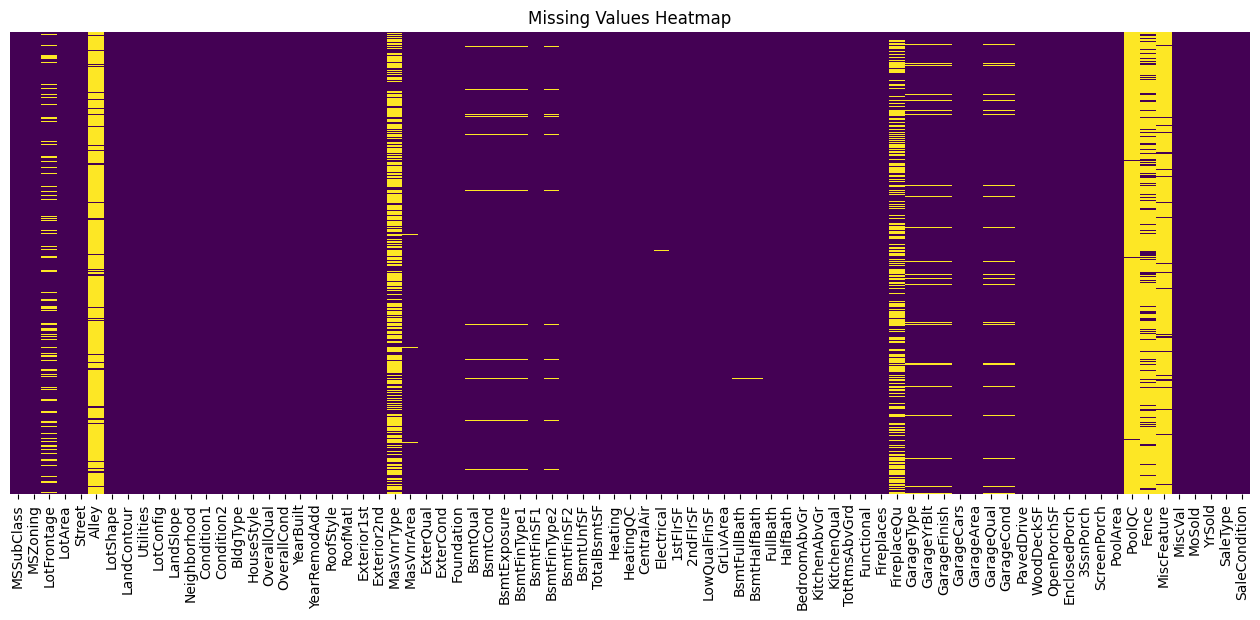

In [53]:
# Set the size
plt.figure(figsize=(16, 6))

# Create the heatmap
sns.heatmap(all_data.isnull(), cbar=False, yticklabels=False , cmap='viridis')

# Add title
plt.title('Missing Values Heatmap')
plt.show()

Dropping the columns with more than 50% missing values

In [54]:
# Creating an empty list to put in it columns with more that 50% missing values
col_to_drop = []

# Creating a for loop to loop through all the columns and computing the missing percentage
for col in all_data.columns:
  missing_percentage = all_data[col].isnull().mean() * 100
  if missing_percentage > 50:
    col_to_drop.append(col)
    print(f"Dropping '{col}' -> missing percentage = {missing_percentage}% ")

# Dropping all the columns with missing values percentage greater than 50%
all_data.drop(columns=col_to_drop , inplace = True)

all_data.shape

Dropping 'Alley' -> missing percentage = 93.21685508735868% 
Dropping 'MasVnrType' -> missing percentage = 60.500171291538194% 
Dropping 'PoolQC' -> missing percentage = 99.65741692360398% 
Dropping 'Fence' -> missing percentage = 80.4385063377869% 
Dropping 'MiscFeature' -> missing percentage = 96.40287769784173% 


(2919, 74)

Finding the column where missing actually means doesn't exist

In [55]:
# Columns where missing means "None" (the feature doesn't exist)
cols_where_missing_means_none = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
]

for col in cols_where_missing_means_none:
    # Only fill if the column still exists in all_data
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna("None")

Filling all the missing categorical data with mode and the missing numerical data with zero

In [56]:
for col in all_data.columns:
  if all_data[col].dtype == 'object':
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  else:
    all_data[col] = all_data[col].fillna(0)

In [57]:
all_data.isnull().sum().sum()

np.int64(0)

Lets fix the target variable (Label)

/tmp/ipython-input-375460187.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train)


<Axes: xlabel='SalePrice', ylabel='Density'>

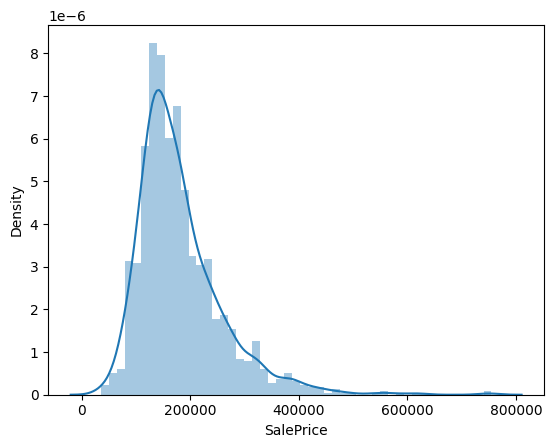

In [58]:
sns.distplot(y_train)

As we can see it is positive skewed we need to normalize it

/tmp/ipython-input-949392415.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_logged)


<Axes: xlabel='SalePrice', ylabel='Density'>

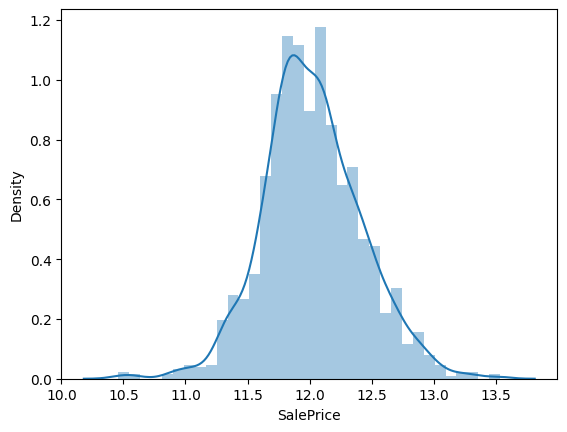

In [59]:
# Use np.log1p which means "log(1 + x)" - handles zero values safely
y_train_logged = np.log1p(y_train)

# verify it looks better
sns.distplot(y_train_logged)

# **#Encoding categorical features**

In [60]:
all_data_encoded = pd.get_dummies(all_data)

In [61]:
all_data_encoded.shape

(2919, 281)

Making sure that X_train and y_train is compatable

In [92]:
# Get the number of rows in the original training data
n_train = len(train)

# Slice the first 'n_train' rows. This is your cleaned training data.
X_train_cleaned = all_data_encoded[:n_train]

# Slice the remaining rows starting from 'n_train'. This is your cleaned test data.
test_cleaned = all_data_encoded[n_train:]

# --- VERIFICATION (Important!) ---
print(f"Original y_train shape: {y_train_logged.shape}")
print(f"Cleaned X_train shape:  {X_train_cleaned.shape}")
print("-" * 30)
print(f"Original test shape:    {test.shape}")
print(f"Cleaned test shape:     {test_cleaned.shape}")

# The number of rows in y_train and X_train_cleaned MUST match.
assert y_train.shape[0] == X_train_cleaned.shape[0]
print("\nSuccess! Shapes match.")

Original y_train shape: (1460,)
Cleaned X_train shape:  (1460, 281)
------------------------------
Original test shape:    (1459, 79)
Cleaned test shape:     (1459, 281)

Success! Shapes match.


In [93]:
# Create a copy of the cleaned features dataframes so we don't modify the original view
final_train_dataset = X_train_cleaned.copy()

# Add y_train into this dataframe as a new column named 'SalePrice'
final_train_dataset['SalePrice'] = y_train_logged

# --- VERIFICATION ---
print(f"Shape of final combined dataset: {final_train_dataset.shape}")

# Let's look at the last few columns to ensure 'SalePrice' is there at the end
print("\nLast 5 columns preview:")
print(final_train_dataset.iloc[:, -5:].head())

Shape of final combined dataset: (1460, 282)

Last 5 columns preview:
   SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                 False                 False                  True   
1                 False                 False                  True   
2                 False                 False                  True   
3                 False                 False                 False   
4                 False                 False                  True   

   SaleCondition_Partial  SalePrice  
0                  False  12.247699  
1                  False  12.109016  
2                  False  12.317171  
3                  False  11.849405  
4                  False  12.429220  


# **#Splitting the final_train_dataset data into X_train , y_train ,X_val , y_val**

In [94]:
from sklearn.model_selection import train_test_split
X_trn , X_val , y_trn , y_val = train_test_split(X_train_cleaned, y_train_logged, test_size=0.2, random_state=42)

# **#Scaling**

In [65]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_trn = sc.fit_transform(X_trn)
X_val = sc.transform(X_val)

# **#Chossing the best regression model as the target variable is continous numbers**

In [96]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_trn,y_trn)

LinearRegression()

# **#Prediction**

In [83]:
y_pred = regressor.predict(X_val)

# **#Evaluation**

In [84]:
from sklearn.metrics import r2_score

r2 = r2_score(y_val, y_pred)

print(f"R-squared (R2): {r2:.4f}")

R-squared (R2): 0.9138


# **#Applying K-fold cross-validation**

In [87]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regressor, X = X_trn , y = y_trn , cv = 10)
print(accuracies.mean())
print(accuracies.std())

0.8263336168270301
0.12876702632114537


# **#Final submission**

In [97]:
# 1. CRITICAL STEP: Scale the test data using the SAME scaler you already fitted
# Do NOT call fit_transform again! Just call .transform()
test_scaled = sc.transform(test_cleaned)

# 2. Make predictions on the SCALED test data
# (These predictions will be in log-scale)
log_predictions = regressor.predict(test_scaled)

# 3. Reverse the log transform to get dollar prices
actual_predictions = np.expm1(log_predictions)

# 4. Create and save submission
submission_df = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': actual_predictions
})

# I'll name it something different so you know it's the new one
submission_df.to_csv('submission_scaled_fixed.csv', index=False)

print("Fixed submission created! Upload 'submission_scaled_fixed.csv'.")

Fixed submission created! Upload 'submission_scaled_fixed.csv'.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
